# PyBullet demo

This notebook demonstrates how to train a USA model on a PyBullet environment. The environment is taken from [here](https://github.com/adubredu/pybullet_kitchen).

To get started, first make sure to install some dependencies:

```bash
pip install pybullet scikit-learn scipy
```

In [1]:
import os

# These environment variables control where training and eval logs are written.
# You can set these in your shell profile as well.
os.environ["RUN_DIR"] = "runs"
os.environ["EVAL_RUN_DIR"] = "eval_runs"
os.environ["MODEL_DIR"] = "models"
os.environ["DATA_DIR"] = "data"

# This is used to set a constant Tensorboard port.
os.environ["TENSORBOARD_PORT"] = str(8989)

import ml.api as ml  # Source: https://github.com/codekansas/ml-starter

# Enables logging to `stdout`.
ml.configure_logging(use_tqdm=True)

# Imports these files to add them to the model and task registry.
from usa.models.point2emb import Point2EmbModel
from usa.tasks.clip_sdf import ClipSdfTask

In [2]:
import pickle as pkl
import zipfile
from pathlib import Path
from typing import Iterator

import cv2
import imageio
import matplotlib.pyplot as plt
import ml.api as ml
import numpy as np
import pybullet as pb
import requests
from IPython.display import Image
from omegaconf import OmegaConf
from torch import Tensor

pybullet build time: Apr 20 2023 16:57:05


In [3]:
pb.connect(pb.DIRECT)
pb.resetSimulation()

pb.setGravity(0, 0, -9.81)
pb.setPhysicsEngineParameter(enableConeFriction=0)

The code below downloads the environment data and adds it to PyBullet.

In [4]:
data_root = Path("data")
data_root.mkdir(exist_ok=True)

# Downloads the dataset, if it is not already downloaded.
if not (data_root / "04_pybullet_data").exists():
    r = requests.get("https://github.com/codekansas/usa/releases/download/v0.0.2/04_pybullet_data.zip", allow_redirects=True)
    with open(data_root / "04_pybullet_data.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile(data_root / "04_pybullet_data.zip", "r") as zip_ref:
        zip_ref.extractall(data_root)

# Loads the URDFs into PyBullet.
pb.setAdditionalSearchPath(str(data_root / "04_pybullet_data"))
kitchen_path = "kitchen_part_right_gen_convex.urdf"
use_fixed_base = True
pb.setGravity(0, 0, -9.81)

floor = pb.loadURDF(
    "floor.urdf",
    useFixedBase=use_fixed_base,
)

kitchen = pb.loadURDF(
    "kitchen_part_right_gen_convex.urdf",
    (-5, 0, 1.477),
    useFixedBase=use_fixed_base,
)

table = pb.loadURDF(
    "table.urdf",
    (1.0, 0, 0),
    pb.getQuaternionFromEuler((0, 0, 1.57)),
    useFixedBase=use_fixed_base,
)

Next, we create a new Kitchen environment.

In [5]:
class Kitchen:
    def __init__(self):
        kitchen_path = "kitchen_part_right_gen_convex.urdf"
        useFixedBase = True
        pb.setGravity(0, 0, -9.81)
        self.floor = pb.loadURDF("floor.urdf", useFixedBase=useFixedBase)
        self.kitchen = pb.loadURDF(kitchen_path, [-5, 0, 1.477], useFixedBase=useFixedBase)
        self.table = pb.loadURDF(
            "table.urdf",
            [1.0, 0, 0],
            pb.getQuaternionFromEuler([0, 0, 1.57]),
            useFixedBase=useFixedBase,
        )

Next, let's collect some samples from the environment. The `PosedRGBDItem` used for training the model has the following description:

```python
class PosedRGBDItem(NamedTuple):
    image: Tensor       # RGB image, with shape (C, H, W)
    depth: Tensor       # Depth image, with shape (1, H, W)
    mask: Tensor        # Valid depth points, with shape (1, H, W), where True means valid
    intrinsics: Tensor  # Camera intrinsics matrix, with shape (3, 3)
    pose: Tensor        # Camera pose matrix, with shape (4, 4)

    def check(self) -> None:
        # Image should have shape (C, H, W)
        assert self.image.dim() == 3
        assert self.image.dtype == torch.float32
        # Depth should have shape (1, H, W)
        assert self.depth.dim() == 3
        assert self.depth.shape[0] == 1
        assert self.depth.dtype == torch.float32
        # Depth shape should match image shape.
        assert self.depth.shape[1:] == self.image.shape[1:]
        assert self.mask.shape[1:] == self.image.shape[1:]
        # Intrinsics should have shape (3, 3)
        assert self.intrinsics.shape == (3, 3)
        assert self.intrinsics.dtype == torch.float64
        # Pose should have shape (4, 4)
        assert self.pose.shape == (4, 4)
        assert self.pose.dtype == torch.float64
```

The intrinsics matrix can be constructed as follows:

```python
def intrinsics_matrix(fx: float, fy: float, cx: float, cy: float) -> np.ndarray:
    intr = np.eye(3, dtype=np.float64)
    intr[0, 0] = fx
    intr[1, 1] = fy
    intr[0, 2] = cx
    intr[1, 2] = cy
    return intr
```

The pose matrix can be constructed from the rotation quaternion and translation vector using this snippet:

```python
import numpy as np
from quaternion import as_rotation_matrix, quaternion  # pip install numpy-quaternion


def as_pose_matrix(pose: list[float]) -> np.ndarray:
    """Converts a list of pose parameters to a pose matrix.

    Args:
        pose: The list of pose parameters, (qx, qy, qz, qw, px, py, pz)

    Returns:
        A (4, 4) pose matrix
    """

    mat = np.eye(4, dtype=np.float64)
    qx, qy, qz, qw, px, py, pz = pose
    mat[:3, :3] = as_rotation_matrix(quaternion(qw, qx, qy, qz))
    mat[:3, 3] = [px, py, pz]
    return mat
```

In the example below, we move the camera around the center point to collect a few frames.

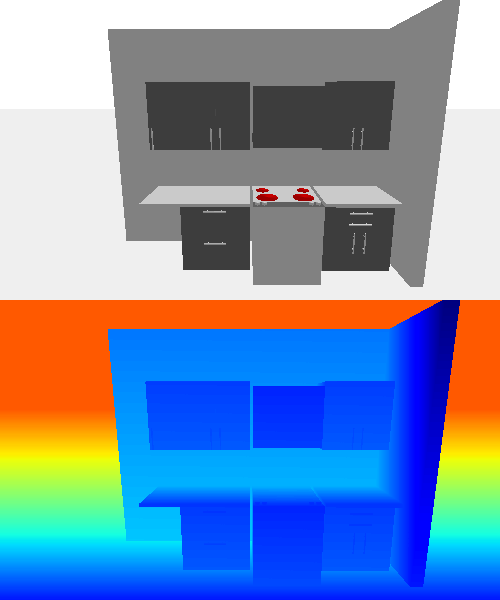

In [6]:
def capture_frame(
    camera_xyz: tuple[float, float, float] = (-5.0, 0.0, 1.477),
    camera_ypr: tuple[float, float, float] = (90.0, -10.0, 0.0),
    camera_distance: float = 3.0,
    camera_planes: tuple[float, float] = (0.01, 100.0),
    pixel_dims: tuple[int, int] = (500, 300),
    camera_fov: float = 60.0,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Captures a single frame, returning RGB and depth information.

    Args:
        camera_xyz: The XYZ coordinates of the camera
        camera_ypr: The yaw, pitch and roll of the camera
        cam_distance: Not sure
        camera_planes: The minimum and maximum rendering distances
        pixel_dims: The shape of the output image, as (W, H)
        camera_fov: The camera field of view
        
    Returns:
        The RGB image with shape (H, W, 3), the depth image with shape (H, W),
        the intrinsics matrix with shape (3, 3), and the pose matrix with
        shape (4, 4).
    """

    yaw, pitch, roll = camera_ypr
    near_plane, far_plane = camera_planes
    pixel_width, pixel_height = pixel_dims

    # Computes the view and projection matrices.
    view_mat = pb.computeViewMatrixFromYawPitchRoll(camera_xyz, camera_distance, yaw, pitch, roll, 2)
    aspect = pixel_width / pixel_height
    proj_mat = pb.computeProjectionMatrixFOV(camera_fov, aspect, near_plane, far_plane)

    # Captures the camera image.
    img_arr = pb.getCameraImage(pixel_width, pixel_height, view_mat, proj_mat)
    img_width, img_height, rgb, depth, *_ = img_arr

    # Reshapes arrays to expected output shape.
    rgb_arr = np.reshape(rgb, (img_height, img_width, 4))[..., :3]
    depth_arr = np.reshape(depth, (img_height, img_width))
    
    # Gets camera intrinsics matrix.
    fx = pixel_width / (2 * np.tan(np.deg2rad(camera_fov) / 2))
    fy = pixel_height / (2 * np.tan(np.deg2rad(camera_fov) / 2))
    cx = pixel_width / 2
    cy = pixel_height / 2
    intr = np.eye(3)
    intr[0, 0] = fx
    intr[1, 1] = fy
    intr[0, 2] = cx
    intr[1, 2] = cy
    
    # Gets the pose matrix.
    pose = np.linalg.inv(np.array(view_mat).reshape(4, 4))
    
    return rgb_arr, depth_arr, intr, pose


def move_camera(
    camera_xyz: tuple[float, float, float],
    camera_ypr: tuple[float, float, float],
) -> tuple[tuple[float, float, float], tuple[float, float, float]]:
    x, y, z = camera_xyz
    yaw, pitch, roll = camera_ypr
    return (
        (x - 0.005, y + 0.01, z),
        (yaw + 0.1, pitch, roll),
    )


def capture_sim(total_steps: int = 100, capture_every: int = 5) -> Iterator[tuple[np.ndarray, np.ndarray]]:
    camera_xyz = (-5.0, 0.0, 1.477)
    camera_ypr = (90.0, -10.0, 0.0)
    for i in range(total_steps):
        camera_xyz, camera_ypr = move_camera(camera_xyz, camera_ypr)
        if i % capture_every == 0:
            yield capture_frame(camera_xyz, camera_ypr)


def write_gif(frames: Iterator[tuple[np.ndarray, ...]], out_file: str | Path, pkl_file: str | Path, *, fps: int = 30) -> None:
    rgb, depth, mask, poses, intrinsics = [], [], [], [], []

    writer = imageio.get_writer(str(out_file), mode="I", fps=fps)
    for rgb_frame, depth_frame, intr, pose in frames:
        # Adds to the lists.
        rgb.append(rgb_frame)
        depth.append(depth_frame)
        mask.append(np.ones_like(depth_frame, dtype=np.uint8))
        poses.append(pose)
        intrinsics.append(intr)

        # Adds the image to the GIF.
        depth_normalized = (depth_frame - np.min(depth_frame)) / (np.max(depth_frame) - np.min(depth_frame) + 1e-3)
        depth_colorized = (plt.cm.jet(depth_normalized)[..., :3] * 255).astype(np.uint8)
        frame = np.concatenate([rgb_frame, depth_colorized], axis=0)
        writer.append_data(frame)

    # Saves the pickle file.
    data = {
        "rgb": np.stack(rgb),
        "depth": np.stack(depth),
        "mask": np.stack(mask),
        "poses": np.stack(poses),
        "intrinsics": np.stack(intrinsics),
    }
    with open(pkl_file, "wb") as f:
        pkl.dump(data, f)

    # Closes the writer.
    writer.close()


def iter_frames() -> Iterator[np.ndarray]:
    pb.resetSimulation()
    kitchen = Kitchen()
    yield from capture_sim()


pkl_path = data_root / "04_recorded_clip.pkl"
write_gif(iter_frames(), "video.gif", pkl_path)
Image("video.gif")

Next, we can train a model on our dataset.

In [7]:
# Using the default config, but overriding the dataset.
config = OmegaConf.load("config.yaml")
config.task.dataset = "pybullet"
config.task.dataset_path = str(pkl_path)

# We still need to explicitly set these variables.
config.trainer.exp_name = "jupyter"
config.trainer.log_dir_name = "test"
config.trainer.base_run_dir = "runs"
config.trainer.run_id = 0

In [8]:
objs = ml.instantiate_config(config)

# Unpacking the different components.
model = objs.model
task = objs.task
optimizer = objs.optimizer
lr_scheduler = objs.lr_scheduler
trainer = objs.trainer

from tensorboard import notebook

# Show Tensorboard inside the notebook.
notebook.display(port=int(os.environ['TENSORBOARD_PORT']))

# Runs the training loop.
trainer.train(model, task, optimizer, lr_scheduler)

100%|██████████████████████████████████████████████████████████████| 350837078/350837078 [00:21<00:00, 16209126.48it/s]


WARNING  2023-04-26 18:41:42 [ml.utils.timer] Finished loading pretrained CLIP model in 23.6 seconds


100%|███████████████████████████████████████████████████████████████████| 1356917/1356917 [00:00<00:00, 1810970.47it/s]

WARNING  2023-04-26 18:41:46 [ml.utils.timer] Finished building clip_sdf in 26.7 seconds
WARNING  2023-04-26 18:41:46 [ml.utils.timer] Finished building task in 26.7 seconds
  INFO   2023-04-26 18:41:46 [ml.trainers.base] Experiment directory: /Users/bbolte/Github/usa-net/notebooks/runs/jupyter/run_0


INFOALL  2023-04-26 18:41:48 [ml.utils.device.auto] Device: [mps:0]
  INFO   2023-04-26 18:41:48 [ml.loggers.tensorboard] Tensorboard command: tensorboard serve --logdir /Users/bbolte/Github/usa-net/notebooks/runs/jupyter/run_0/test/tensorboard/18-41-19 --bind_all --port 8989 --reload_interval 15
  INFO   2023-04-26 18:41:48 [ml.core.registry] Components:
 ↪ Model: usa.models.point2emb.Point2EmbModel (/Users/bbolte/.conda/envs/usa-net/lib/python3.10/site-packages/usa/models/point2emb.py)
 ↪ Task: usa.tasks.clip_sdf.ClipSdfTask (/Users/bbolte/.conda/envs/usa-net/lib/python3.10/site-packages/usa/tasks/clip_sdf.py)
 ↪ Trainer: ml.trainers.sl.SupervisedLearningSlurmTrainer (/Users/bbolte/.conda/envs/usa-net/lib/python3.10/site-packages/ml/trainers/sl.py)
 ↪ Optimizer: ml.optimizers.adam.AdamOptimizer (/Users/bbolte/.conda/envs/usa-net/lib/python3.10/site-packages/ml/optimizers/adam.py)
 ↪ LR Scheduler: ml.lr_schedulers.linear.LinearLRScheduler (/Users/bbolte/.conda/envs/usa-net/lib/python3

  INFO   2023-04-26 18:41:48 [ml.trainers.base] Saved config to /Users/bbolte/Github/usa-net/notebooks/runs/jupyter/run_0/config.yaml


NotImplementedError: Unsupported dataset key: pybullet